In [6]:
import config

from tqdm import tqdm
import warnings
import os
from hyena_dna.standalone_hyenadna import HyenaDNAModel
import torch
import pickle
import pandas as pd
import numpy as np
import re
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, make_scorer, f1_score, classification_report, confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.decomposition import PCA
import seaborn as sns
import matplotlib.pyplot as plt


os.environ['PYTHONWARNINGS'] = 'ignore'
warnings.filterwarnings('ignore')
os.chdir(config.DIR_ROOT)

# Logistic Regression

In [3]:
name_to_embedding = {}
name_to_type = {}
path_to_hyena_embedding = os.path.join(config.DIR_INCEST_MANY, 'hyena_embeddings_and_types.pkl')
with open(path_to_hyena_embedding, "rb") as f:
    data = pickle.load(f)


name_to_embedding = data['embeddings']
name_to_type = data['types']


path_to_filtered = os.path.join(config.DIR_INCEST_MANY, 'repbase_filtered.csv')
df_filtered = pd.read_csv(path_to_filtered)
names = list(df_filtered['name'])


X = np.array([name_to_embedding[name] for name in names])
y = np.array([name_to_type[name] for name in names])

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y,
    test_size=0.2,
    random_state=1,
    stratify=y
)


cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)

param_grid = {
    "C": [0.01, 0.1, 1.0, 10.0],
    "solver": ["lbfgs"],
    "penalty": ["l2"],
    "multi_class": ["auto"],
    "class_weight": ["balanced"]
}

scoring = {
    "accuracy": "accuracy",
    "f1_macro": make_scorer(f1_score, average="macro")
}

gs = GridSearchCV(
    estimator=LogisticRegression(max_iter=2000),
    param_grid=param_grid,
    scoring=scoring,
    refit="f1_macro",
    cv=cv,
    n_jobs=-1,
    return_train_score=True,
    verbose=0
)

gs.fit(X_train, y_train)

print("Лучшие параметры:", gs.best_params_)
print("Лучшая CV F1-macro:", gs.best_score_)

best_model = gs.best_estimator_

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV] END C=0.01, class_weight=balanced, multi_class=auto, penalty=l2, solver=lbfgs; total time=   8.0s
[CV] END C=0.01, class_weight=balanced, multi_class=auto, penalty=l2, solver=lbfgs; total time=   8.4s
[CV] END C=0.01, class_weight=balanced, multi_class=auto, penalty=l2, solver=lbfgs; total time=   8.5s
[CV] END C=0.01, class_weight=balanced, multi_class=auto, penalty=l2, solver=lbfgs; total time=   8.8s
[CV] END C=0.01, class_weight=balanced, multi_class=auto, penalty=l2, solver=lbfgs; total time=   9.1s
[CV] END C=0.1, class_weight=balanced, multi_class=auto, penalty=l2, solver=lbfgs; total time=  21.6s
[CV] END C=0.1, class_weight=balanced, multi_class=auto, penalty=l2, solver=lbfgs; total time=  21.7s
[CV] END C=0.1, class_weight=balanced, multi_class=auto, penalty=l2, solver=lbfgs; total time=  23.1s
[CV] END C=0.1, class_weight=balanced, multi_class=auto, penalty=l2, solver=lbfgs; total time=  20.8s
[CV] END C=0.1, c

Accuracy: 0.3453710920585433


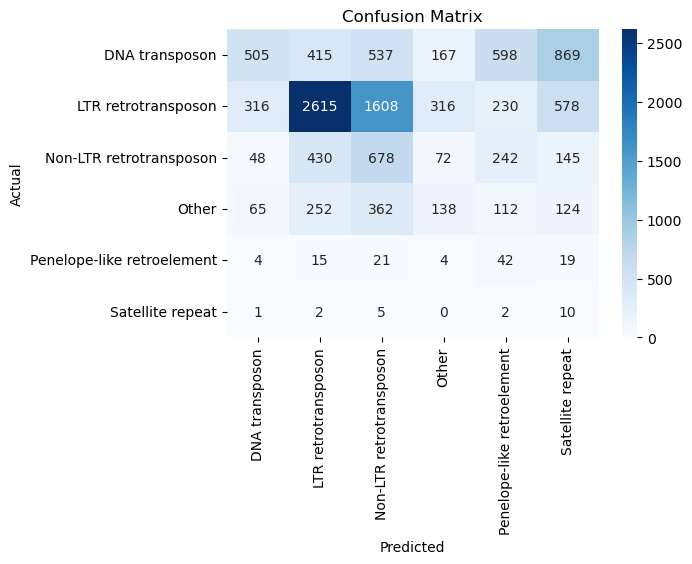

                            precision    recall  f1-score   support

            DNA transposon       0.54      0.16      0.25      3091
       LTR retrotransposon       0.70      0.46      0.56      5663
   Non-LTR retrotransposon       0.21      0.42      0.28      1615
                     Other       0.20      0.13      0.16      1053
Penelope-like retroelement       0.03      0.40      0.06       105
          Satellite repeat       0.01      0.50      0.01        20

                  accuracy                           0.35     11547
                 macro avg       0.28      0.35      0.22     11547
              weighted avg       0.54      0.35      0.39     11547



In [11]:
y_pred = best_model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
class_names = sorted(list(set(y_test) | set(y_pred)))
cm = confusion_matrix(y_test, y_pred, labels=class_names)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()
print(classification_report(y_test, y_pred))

In [13]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)

param_grid = {
    "C": [0.01, 0.1, 1.0, 10.0],
    "kernel": ["linear", "rbf"],
    "class_weight": ["balanced"]
}

scoring = {
    "accuracy": "accuracy",
    "f1_macro": make_scorer(f1_score, average="macro")
}

gs = GridSearchCV(
    estimator=SVC(max_iter=1000),
    param_grid=param_grid,
    scoring=scoring,
    refit="f1_macro",
    cv=cv,
    n_jobs=-1,
    return_train_score=False,
    verbose=0
)

gs.fit(X_scaled, y_train)

print("Лучшие параметры:", gs.best_params_)
print("Лучшая CV F1-macro:", gs.best_score_)

best_model = gs.best_estimator_

Fitting 5 folds for each of 8 candidates, totalling 40 fits
Лучшие параметры: {'C': 10.0, 'class_weight': 'balanced', 'kernel': 'linear'}
Лучшая CV F1-macro: 0.11864239830388054


Accuracy: 0.3453710920585433


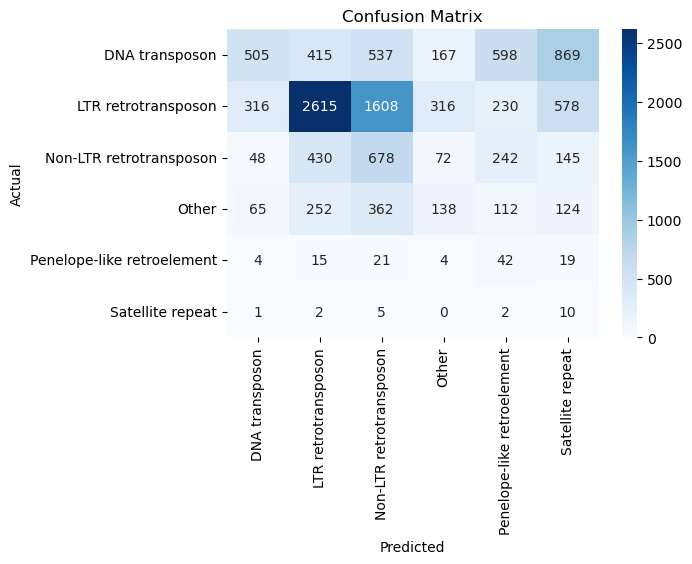

                            precision    recall  f1-score   support

            DNA transposon       0.54      0.16      0.25      3091
       LTR retrotransposon       0.70      0.46      0.56      5663
   Non-LTR retrotransposon       0.21      0.42      0.28      1615
                     Other       0.20      0.13      0.16      1053
Penelope-like retroelement       0.03      0.40      0.06       105
          Satellite repeat       0.01      0.50      0.01        20

                  accuracy                           0.35     11547
                 macro avg       0.28      0.35      0.22     11547
              weighted avg       0.54      0.35      0.39     11547



In [13]:
y_pred = best_model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
class_names = sorted(list(set(y_test) | set(y_pred)))
cm = confusion_matrix(y_test, y_pred, labels=class_names)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()
print(classification_report(y_test, y_pred))

Accuracy: 0.3453710920585433


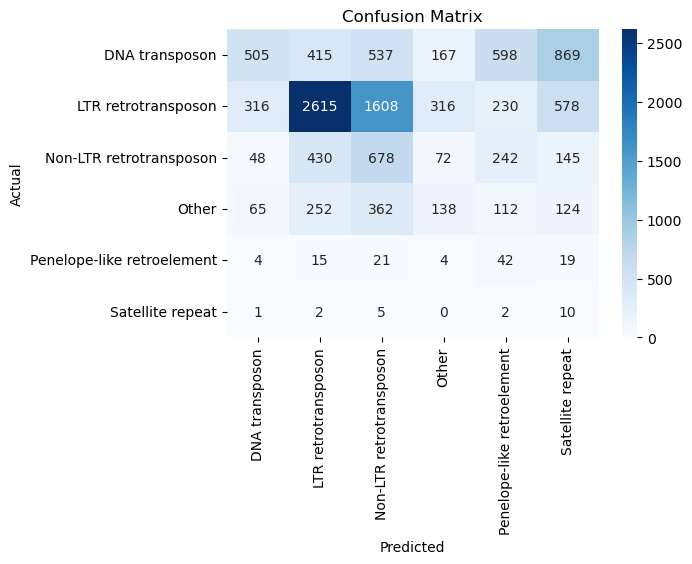

                            precision    recall  f1-score   support

            DNA transposon       0.54      0.16      0.25      3091
       LTR retrotransposon       0.70      0.46      0.56      5663
   Non-LTR retrotransposon       0.21      0.42      0.28      1615
                     Other       0.20      0.13      0.16      1053
Penelope-like retroelement       0.03      0.40      0.06       105
          Satellite repeat       0.01      0.50      0.01        20

                  accuracy                           0.35     11547
                 macro avg       0.28      0.35      0.22     11547
              weighted avg       0.54      0.35      0.39     11547



In [12]:
lda = LinearDiscriminantAnalysis()
lda.fit(X_train, y_train)
y_pred = lda.predict(X_test)
y_pred = best_model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
class_names = sorted(list(set(y_test) | set(y_pred)))
cm = confusion_matrix(y_test, y_pred, labels=class_names)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()
print(classification_report(y_test, y_pred))